# Библиотеки

In [1]:
# Работа с ОС (пути, переменные окружения)
import os

# PostgreSQL драйвер (подключение к БД, выполнение SQL)
import psycopg2

# Численные операции и массивы
import numpy as np

# OpenCV — декодирование изображений и аугментации
import cv2

# Визуализация изображений и графиков
import matplotlib.pyplot as plt

# Загрузка переменных окружения из .env
from dotenv import load_dotenv

# PyTorch — основной фреймворк для ML
import torch
import torch.nn as nn

# Dataset и DataLoader — стандартные абстракции PyTorch
from torch.utils.data import Dataset, DataLoader


# Пример данных из БД

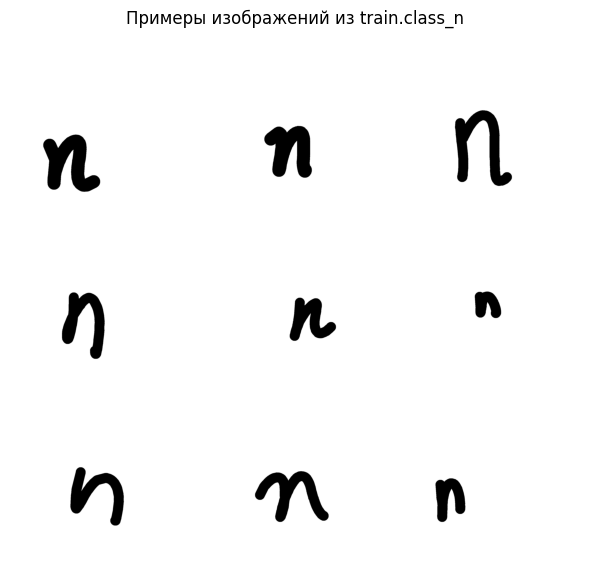

In [2]:
# Загружаем переменные окружения из ../.env
# Там лежат PG_HOST, PG_USER и т.д.
load_dotenv("../.env")

# Подключаемся к PostgreSQL
conn = psycopg2.connect(
    host=os.getenv("PG_HOST"),
    port=os.getenv("PG_PORT"),
    user=os.getenv("PG_USER"),
    password=os.getenv("PG_PASSWORD"),
    dbname=os.getenv("PG_DB"),
)

# Создаём курсор для выполнения SQL-запросов
cur = conn.cursor()

# Выбираем конкретный класс для примера
class_name = 'class_n'

# SQL-запрос: берём 9 изображений из таблицы train.class_n
query = '''
SELECT image_data
FROM train."''' + class_name + '''"
LIMIT 9
'''

# Выполняем запрос
cur.execute(query)

# Получаем все строки (каждая строка — BYTEA с изображением)
rows = cur.fetchall()

# Закрываем соединение (дальше оно не нужно)
cur.close()
conn.close()

# Создаём фигуру для отображения изображений
plt.figure(figsize=(6, 6))

# Проходимся по изображениям
for i, (img_bytes,) in enumerate(rows, 1):
    # Преобразуем BYTEA → numpy uint8
    img_array = np.frombuffer(img_bytes, np.uint8)

    # Декодируем PNG/JPEG → grayscale изображение
    img = cv2.imdecode(img_array, cv2.IMREAD_GRAYSCALE)

    # Рисуем изображение в сетке 3x3
    plt.subplot(3, 3, i)
    plt.imshow(img, cmap="gray")
    plt.axis("off")

# Общий заголовок
plt.suptitle(f"Примеры изображений из train.{class_name}")
plt.tight_layout()
plt.show()


# Подключение к БД

In [3]:
# Снова загружаем .env (безопасно и явно)
load_dotenv("../.env")

# Подключаемся к БД
conn = psycopg2.connect(
    host=os.getenv("PG_HOST"),
    port=os.getenv("PG_PORT"),
    user=os.getenv("PG_USER"),
    password=os.getenv("PG_PASSWORD"),
    dbname=os.getenv("PG_DB"),
)

# Курсор для SQL-запросов
cur = conn.cursor()

# Маппинг классов → индексы

In [4]:
# Цифры 0–9
digits = [str(i) for i in range(10)]

# Заглавные буквы A–Z
uppercase = [chr(i) for i in range(ord('A'), ord('Z') + 1)]

# Строчные буквы a–z
lowercase = [chr(i) for i in range(ord('a'), ord('z') + 1)]

# Итоговый список классов (строго фиксированный порядок!)
class_names = digits + uppercase + lowercase

# Маппинг: символ → имя таблицы в БД
table_name_map = {}

# Цифры лежат в таблицах class_0 ... class_9
for c in digits:
    table_name_map[c] = f"class_{c}"

# Заглавные буквы лежат в class_A_caps ...
for c in uppercase:
    table_name_map[c] = f"class_{c}_caps"

# Строчные буквы лежат в class_a ...
for c in lowercase:
    table_name_map[c] = f"class_{c}"

# Маппинг класс → индекс (для CrossEntropyLoss)
class_to_idx = {name: idx for idx, name in enumerate(class_names)}

# Обратный маппинг индекс → класс (для inference)
idx_to_class = {idx: name for name, idx in class_to_idx.items()}

# Общее количество классов
num_classes = len(class_names)

print("Всего классов:", num_classes)
print("Пример маппинга:")
for k in list(class_to_idx.keys())[:62]:
    print(f"{k} → {class_to_idx[k]}")

Всего классов: 62
Пример маппинга:
0 → 0
1 → 1
2 → 2
3 → 3
4 → 4
5 → 5
6 → 6
7 → 7
8 → 8
9 → 9
A → 10
B → 11
C → 12
D → 13
E → 14
F → 15
G → 16
H → 17
I → 18
J → 19
K → 20
L → 21
M → 22
N → 23
O → 24
P → 25
Q → 26
R → 27
S → 28
T → 29
U → 30
V → 31
W → 32
X → 33
Y → 34
Z → 35
a → 36
b → 37
c → 38
d → 39
e → 40
f → 41
g → 42
h → 43
i → 44
j → 45
k → 46
l → 47
m → 48
n → 49
o → 50
p → 51
q → 52
r → 53
s → 54
t → 55
u → 56
v → 57
w → 58
x → 59
y → 60
z → 61


# Функция загрузки схемы

In [5]:
def load_schema(schema):
    """
    Загружает все изображения из схемы (train или test)
    и возвращает список (image, label)
    """
    data = []

    # Проходимся по ВСЕМ классам
    for class_name in class_names:
        # Имя таблицы в БД
        table = table_name_map[class_name]

        # SQL-запрос: берём все изображения из таблицы
        query = f'''
            SELECT image_data
            FROM {schema}."{table}"
        '''

        # Выполняем запрос
        cur.execute(query)
        rows = cur.fetchall()

        # Каждая строка — одно изображение
        for (img_bytes,) in rows:
            # BYTEA → numpy
            img_array = np.frombuffer(img_bytes, np.uint8)

            # Декодирование → grayscale
            img = cv2.imdecode(img_array, cv2.IMREAD_GRAYSCALE)

            # Приводим к 28x28
            img = cv2.resize(img, (28, 28))

            # Нормализация в диапазон [0, 1]
            img = img.astype(np.float32) / 255.0

            # Добавляем канал: (1, 28, 28)
            img = np.expand_dims(img, axis=0)

            # Получаем числовую метку класса
            label = class_to_idx[class_name]

            # Сохраняем пару (картинка, метка)
            data.append((img, label))

    return data

# Загрузка всех данных из БД → train_df, test_df

In [6]:
# Загружаем тренировочные данные
train_data = load_schema("train")

# Загружаем тестовые данные
test_data  = load_schema("test")

# Закрываем соединение с БД
cur.close()
conn.close()

print(f"Train samples: {len(train_data)}")
print(f"Test samples:  {len(test_data)}")

Train samples: 2728
Test samples:  682


# PyTorch Dataset + аугментация

In [7]:
class HandwrittenDataset(Dataset):
    def __init__(self, data, train=False):
        # data — список (img, label)
        self.data = data

        # Флаг: тренировочный ли датасет
        self.train = train

    def __len__(self):
        # Размер датасета
        return len(self.data)

    def augment(self, img):
        """
        Простая аугментация:
        - поворот
        - сдвиг
        """
        # Убираем канал: (1, 28, 28) → (28, 28)
        img = img[0]

        # Случайный поворот
        if np.random.rand() < 0.5:
            angle = np.random.uniform(-15, 15)
            M = cv2.getRotationMatrix2D((14, 14), angle, 1)
            img = cv2.warpAffine(img, M, (28, 28))

        # Случайный сдвиг
        if np.random.rand() < 0.3:
            shift_x = np.random.randint(-2, 3)
            shift_y = np.random.randint(-2, 3)
            M = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
            img = cv2.warpAffine(img, M, (28, 28))

        # Возвращаем обратно (1, 28, 28)
        return np.expand_dims(img, 0)

    def __getitem__(self, idx):
        # Берём элемент по индексу
        img, label = self.data[idx]

        # Аугментация только для train
        if self.train:
            img = self.augment(img)

        # Возвращаем torch.Tensor
        return (
            torch.tensor(img, dtype=torch.float32),
            torch.tensor(label, dtype=torch.long)
        )

# DataLoader

In [8]:
# Тренировочный датасет (с аугментацией)
train_ds = HandwrittenDataset(train_data, train=True)

# Тестовый датасет (без аугментации)
test_ds  = HandwrittenDataset(test_data, train=False)

# DataLoader — батчи + shuffle
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)

# Модель CNN

In [9]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Сверточная часть (feature extractor)
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 14x14

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 7x7

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Полносвязная классификация
        self.classifier = nn.Sequential(
            nn.Linear(128 * 7 * 7, 512),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # Прогон через CNN
        x = self.features(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Классификация
        return self.classifier(x)

# Оптимизация и scheduler

In [10]:
device = torch.device("cpu")

model = CNN(num_classes).to(device)

# Функция потерь для multi-class классификации
criterion = nn.CrossEntropyLoss()

# Adam — быстрый и стабильный оптимизатор
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Scheduler — уменьшаем LR каждые 10 эпох
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=10, gamma=0.3
)

# Циклы обучения и оценки

In [11]:
def train_epoch(model, loader):
    model.train()
    total_loss = 0
    correct = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (out.argmax(1) == y).sum().item()
    
    scheduler.step()
    acc = correct / len(loader.dataset)
    return total_loss, acc


def eval_epoch(model, loader):
    model.eval()
    correct = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            correct += (out.argmax(1) == y).sum().item()

    return correct / len(loader.dataset)

# Обучение + сохранение лучшей модели

In [12]:
%%time

train_losses = []
train_accs = []
test_accs = []

EPOCHS = 30
best_acc = 0.0

for epoch in range(EPOCHS):
    loss, train_acc = train_epoch(model, train_loader)
    test_acc = eval_epoch(model, test_loader)

    train_losses.append(loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), "best_model.pt")

    print(
        f"Epoch {epoch+1:02d}/{EPOCHS} | "
        f"Loss: {loss:.2f} | "
        f"Train Acc: {train_acc:.4f} | "
        f"Test Acc: {test_acc:.4f}"
    )


Epoch 01/30 | Loss: 172.72 | Train Acc: 0.0440 | Test Acc: 0.0777
Epoch 02/30 | Loss: 142.82 | Train Acc: 0.1202 | Test Acc: 0.1540
Epoch 03/30 | Loss: 110.51 | Train Acc: 0.2702 | Test Acc: 0.4047
Epoch 04/30 | Loss: 83.53 | Train Acc: 0.4120 | Test Acc: 0.5191
Epoch 05/30 | Loss: 66.60 | Train Acc: 0.5282 | Test Acc: 0.5982
Epoch 06/30 | Loss: 57.23 | Train Acc: 0.5883 | Test Acc: 0.6569
Epoch 07/30 | Loss: 50.26 | Train Acc: 0.6210 | Test Acc: 0.6935
Epoch 08/30 | Loss: 42.45 | Train Acc: 0.6844 | Test Acc: 0.7375
Epoch 09/30 | Loss: 39.39 | Train Acc: 0.6990 | Test Acc: 0.7141
Epoch 10/30 | Loss: 36.34 | Train Acc: 0.7144 | Test Acc: 0.7434
Epoch 11/30 | Loss: 30.05 | Train Acc: 0.7705 | Test Acc: 0.7977
Epoch 12/30 | Loss: 25.23 | Train Acc: 0.8072 | Test Acc: 0.7889
Epoch 13/30 | Loss: 24.69 | Train Acc: 0.7991 | Test Acc: 0.8079
Epoch 14/30 | Loss: 23.23 | Train Acc: 0.8167 | Test Acc: 0.8196
Epoch 15/30 | Loss: 22.61 | Train Acc: 0.8109 | Test Acc: 0.8167
Epoch 16/30 | Loss: 21

# Графики Loss и Accuracy

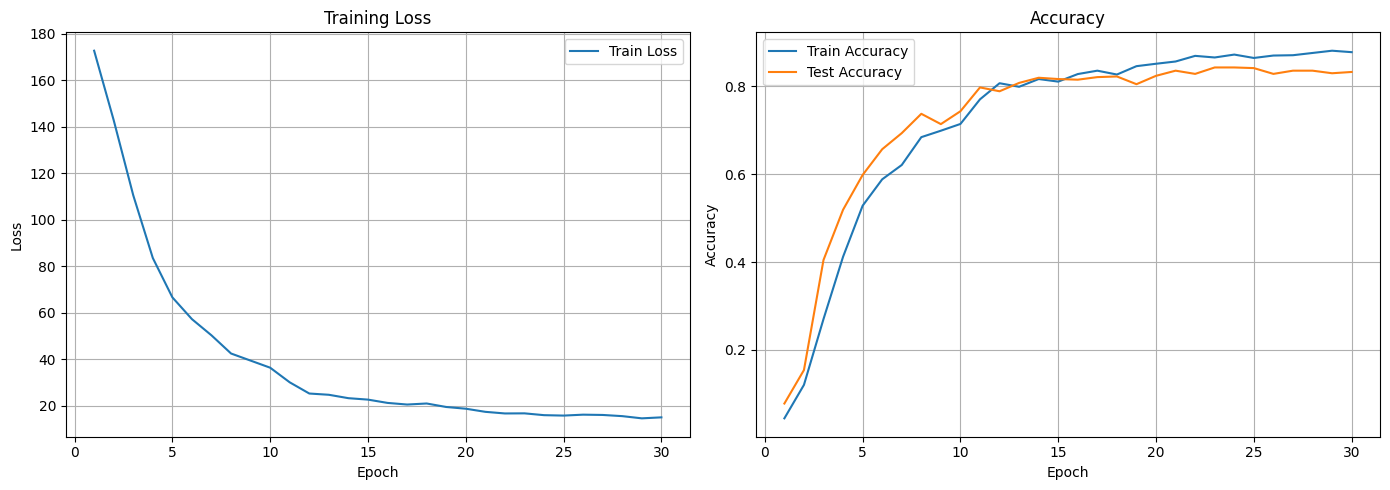

In [13]:
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label="Train Accuracy")
plt.plot(epochs, test_accs, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Финальный замер точности на ВСЁМ test

In [14]:
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        preds = out.argmax(dim=1)

        correct += (preds == y).sum().item()
        total += y.size(0)

final_test_acc = correct / total

print(f"Final Test Accuracy: {final_test_acc:.4f}")

Final Test Accuracy: 0.8328


# Финальное сохранение модели

In [15]:
torch.save({
    "model_state_dict": model.state_dict(),
    "class_to_idx": class_to_idx,
    "idx_to_class": idx_to_class,
    "num_classes": num_classes
}, "handwritten_cnn_best.pt")
